# Scraping

In [62]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline
# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from itertools import cycle
import matplotlib.pyplot as plt
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [63]:
from pyquery import PyQuery as pq
from bs4 import BeautifulSoup
# The "requests" library makes working with HTTP requests easier
# than the built-in urllib libraries.
import requests

In [3]:
# THIS IS THE CODE I USED TO SCRAPE DATA FROM atpworldtour.com. No need to run it, as we stored it in
# our pickle file, stats_dict

# we do this for every year and every surface... three sets of serve and return dicts per year, 
# containing info on each player
stats_dict = {}
surfaces = ["clay","hard","grass"]
stat_type = ["1st-serve","1st-serve-points-won","2nd-serve-points-won","1st-serve-return-points-won","2nd-serve-return-points-won"]

for types in stat_type:
    stats_dict[types] = {}
    for surface in surfaces:
        print surface
        stats_dict[types][surface] = {}
        for i in range(1992,2016):
            time.sleep(1)
            print i
            returns = 'http://www.atpworldtour.com/en/stats/%(what)s/%(year)s/%(surface)s/all/' % \
            {"year": str(i), "surface": surface, "what": types}
            returns = requests.get(returns)
            returns = BeautifulSoup(returns.text, "html.parser")
            rows = returns.find("table", attrs={"class": "stats-listing-table"}).find_all("tr", attrs={"class": "stats-listing-row"})[0:]
            names = returns.find("table", attrs={"class": "stats-listing-table"}).find_all("td", attrs={"class": "stats-listing-name"})
            #print returns
            #rows = returns.find_all("tr", attrs={"class": "stats-listing-row"})[0:]
            #names = returns.find_all("td", attrs={"class": "stats-listing-name"})

            name_list = []

            # collect player names from webpage table
            for name in names:
                store = str(name.find("a").get("href"))
                a,b,store = store.partition("players/")
                store,a,b = store.partition("/")
                store.replace('-',' ')
                name_list.append(store)
            # create dataframe with player names
            our_df = pd.DataFrame(name_list)
            our_df.columns = ['player']
            # initialize empty lists
            stats_perc = []
            # iterate through tables rows and store serving statistics in lists
            for row in rows:
                info = row.find_all("td")[5:9]
                # index up to 2 so I get rid of the % sign
                stats_perc.append(int(str(info[0].text).replace("%","")))

            our_df[types] = stats_perc
            stats_dict[types][surface][i] = our_df

stats_dict

clay
1992


ConnectionError: HTTPConnectionPool(host='www.atpworldtour.com', port=80): Max retries exceeded with url: /en/stats/1st-serve/1992/clay/all/ (Caused by NewConnectionError('<requests.packages.urllib3.connection.HTTPConnection object at 0x109faf7d0>: Failed to establish a new connection: [Errno 61] Connection refused',))

In [ ]:
import cPickle as pickle
with open('stats_dict.p', 'wb') as fp:
    pickle.dump(stats_dict, fp)

# Point by Point Simulator

Now we build a function that lets us simulate a match between any top-100 players on any surface over any of the past 25 years. The functions are designed to simulate, check, convert, and display points in tennis' scoring system. After a random coin flip, one of the two players begins serving and the match progresses until one player wins two out of three sets.

In [64]:
# here we load in our dictionary of player's serve and return statistics, scraped from atpworldtour.com
import cPickle as pickle
with open('stats_dict.p', 'rb') as fp:
    stats_dict = pickle.load(fp)

In [5]:
# function to convert dict of two-element list scores into proper overall score; does not check for valid scores
def get_score(points):
    # unless we are in a tiebreaker, code converts point score from number format to tennis' 15-30-40-deuce format
    if points['game'] != [6,6]:
        point_score = [int(p)*15 for p in points['point']]
        for i in range(0,len(point_score)):
            if point_score[i] == 45:
                point_score[i] = 40
        if max(point_score) > 40:
            if point_score[0] > point_score[1]:
                point_score = ['AD','40']
            if point_score[0] < point_score[1]:
                point_score = ['40','AD']
            if point_score[0] == point_score[1]:
                point_score = ['40','40']
        return str(points['set'][0]) + '-' + str(points['set'][1]) + ', ' + str(points['game'][0]) +\
        '-' + str(points['game'][1]) + ', ' + str(point_score[0]) + '-' + str(point_score[1])
    else:
        return str(points['set'][0]) + '-' + str(points['set'][1]) + ', ' + str(points['game'][0]) +\
        '-' + str(points['game'][1]) + ', ' + str(points['point'][0]) + '-' + str(points['point'][1])

In [6]:
# check to see if a game should be over in tennis
# I will first write this treating the tiebreaker as a typical fifteenth game with a single server
# then I will later update it to reflect an actual tiebreaker
score = {}
score['set'] = [1,0]
score['game'] = [6,6]
score['point'] = [7,9]

def check_score(points):
    # first we check the points score
    #if max(points['point']) == 0:
    #    print str(names[server]) + ' serving'
    
    # if we are not in a tiebreaker, proceed with regular scoring
    if points['game'] != [6,6]:
        if max(points['point']) < 4:
            return points
        if max(points['point']) >= 4:
            if (max(points['point'])-min(points['point'])) < 2:
                return points
            else:
                # if the difference in points is 2, we reset the point score and update the game score
                if points['point'][0] > points['point'][1]:
                    points['game'][0] += 1
                    # I switch the server after any time the game score is updated
                    index = server_I.next()
                    global server
                    global serving
                    server = serving[index]
                if points['point'][1] > points['point'][0]:
                    points['game'][1] += 1
                    index = server_I.next()
                    global server
                    global serving
                    server = serving[index]
                points['point'] = [0,0]
    #if we are in a tiebreaker, switch serve every two points and end once a player gets to seven and wins by two
    elif points['game'] == [6,6]:
        '''
        if (sum(points['point'])%2 == 1):
            # switch after points with remainder one, since you switch serve after the first and every two after
            index = server_I.next()
            global server
            global serving
            server = serving[index]
            print points['point']
            print str(names[server]) + ' serving'
            return points
        
        '''
        # now check if tiebreak should be over
        if max(points['point']) >= 7 and ((max(points['point'])-min(points['point'])) >= 2):
            if points['point'][0] > points['point'][1]:
                print get_score(points)
                points['game'][0] += 1
                # I switch the server after any time the game score is updated
                index = server_I.next()
                global server
                global serving
                server = serving[index]
            if points['point'][1] > points['point'][0]:
                print get_score(points)
                points['game'][1] += 1
                index = server_I.next()
                global server
                global serving
                server = serving[index]
            points['point'] = [0,0]
        # otherwise, tiebreak continues
        else:
            return points
            
    # now we check the game score
    if max(points['game']) < 6:
        print str(names[server]) + ' serving'
        return points
    if points['game'] == [6,6] and points['point'] == [0,0]:
        print str(names[server]) + ' serving'
        return points
    # my next logical statement covers all cases where a player has reached 6 or more games except 6-5
    if (max(points['game']) - min(points['game'])) >= 2 or max(points['game']) == 7:
        if points['game'][0] > points['game'][1]:
            points['set'][0] += 1
            #print str(names[server]) + ' serving'
        if points['game'][1] > points['game'][0]:
            points['set'][1] += 1
            #print str(names[server]) + ' serving'
        points['game'] = [0,0]

    # now we check the set score
    if max(points['set']) < 2:
        print str(names[server]) + ' serving'
        return points
    else:
        #print "Game, Set, Match."
        return points

<ipython-input-6-f09f8e74b9a6>:33: SyntaxWarning: name 'server' is assigned to before global declaration
  global server
<ipython-input-6-f09f8e74b9a6>:34: SyntaxWarning: name 'serving' is used prior to global declaration
  global serving
<ipython-input-6-f09f8e74b9a6>:58: SyntaxWarning: name 'server' is assigned to before global declaration
  global server
<ipython-input-6-f09f8e74b9a6>:59: SyntaxWarning: name 'serving' is used prior to global declaration
  global serving
<ipython-input-6-f09f8e74b9a6>:65: SyntaxWarning: name 'server' is assigned to before global declaration
  global server
<ipython-input-6-f09f8e74b9a6>:66: SyntaxWarning: name 'serving' is used prior to global declaration
  global serving


In [7]:
def point(first_serve_perc,first_serve_win,second_serve_win,score):
    rando = np.random.uniform()
    if rando < first_serve_perc:
        point = np.random.binomial(1,first_serve_win)
    if rando > first_serve_perc:
        point = np.random.binomial(1,second_serve_win)
    #point_chex.append(point)
    # depending on who is serving, I must assign the won and lost points accordingly
    if (point == 1 and server == 'p1') or (point == 0 and server == 'p2'):
        score[0] += 1
    else:
        score[1] += 1
    return score

In [8]:
# let's get started

def simulate(mast_dict,p1,p2):
    outcomes = []
    
    # set up indicator variable to designate who is serving
    global server_I
    server_I = cycle(range(2))
    # set up dict so I can index my iterator to find the server in a given game
    global serving
    serving = ['p1','p2']
    global server
    
    # flip a coin to get this match started
    if np.random.uniform(0,1) > .5:
        print "%s to serve" % (p1)
        index = server_I.next()
        server = serving[index]
    else:
        print "%s to serve" % (p2)
        server_I.next()
        index = server_I.next()
        server = serving[index]

    # initialize empty scoreboards
    score = {}
    score['set'] = [0,0]
    score['game'] = [0,0]
    score['point'] = [0,0]

    # now we get the party started...
    print get_score(score)
    while max(check_score(score)['set']) < 2:
        
        score['point'] = point(mast_dict[server]['1st_serve%'],mast_dict[server]['1st_serve_win'],mast_dict[server]['2nd_serve_win'],score['point'])
        score = check_score(score)
        print get_score(score)
        # checker
        if score['game'] == [6,6] and sum(score['point'])%2 == 1:
            index = server_I.next()
            global server
            global serving
            server = serving[index]
            print str(names[server]) + ' serving'
            
    if max(check_score(score)['set']) == 2:
        print "Game, Set, Match."
        global names
        if check_score(score)['set'][0] == 2:
            print names['p1'] + ' wins.'
        else:
            print names['p2'] + ' wins'

<ipython-input-8-2bf773be27ce>:41: SyntaxWarning: name 'server' is assigned to before global declaration
  global server
<ipython-input-8-2bf773be27ce>:42: SyntaxWarning: name 'serving' is assigned to before global declaration
  global serving
<ipython-input-8-2bf773be27ce>:48: SyntaxWarning: name 'names' is used prior to global declaration
  global names


In [9]:
def match_simulator(player_1,player_2,year,surface):
    # names dict for future reference
    global names 
    names = {'p1': player_1,'p2': player_2}
    
    # split our dictionary into five dataframes for each relevant player statistic
    first_perc = stats_dict['1st-serve'][surface][year]
    first_serve = stats_dict['1st-serve-points-won'][surface][year]
    second_serve = stats_dict['2nd-serve-points-won'][surface][year]
    first_return = stats_dict['1st-serve-return-points-won'][surface][year]
    second_return = stats_dict['2nd-serve-return-points-won'][surface][year]
    
    # extract serve and return percentages for player 1 and player 2 from the database
    player1_info = {'1st_serve%':first_perc.loc[first_perc['player'] == player_1]['1st-serve'].values[0],\
                '1st_serve_win':first_serve.loc[first_serve['player'] == player_1]['1st-serve-points-won'].values[0],\
                '2nd_serve_win':second_serve.loc[second_serve['player'] == player_1]['2nd-serve-points-won'].values[0],\
                '1st_return_win':first_return.loc[first_return['player'] == player_1]['1st-serve-return-points-won'].values[0],\
                '2nd_return_win':second_return.loc[second_return['player'] == player_1]['2nd-serve-return-points-won'].values[0]}

    player2_info = {'1st_serve%':first_perc.loc[first_perc['player'] == player_2]['1st-serve'].values[0],\
                '1st_serve_win':first_serve.loc[first_serve['player'] == player_2]['1st-serve-points-won'].values[0],\
                '2nd_serve_win':second_serve.loc[second_serve['player'] == player_2]['2nd-serve-points-won'].values[0],\
                '1st_return_win':first_return.loc[first_return['player'] == player_2]['1st-serve-return-points-won'].values[0],\
                '2nd_return_win':second_return.loc[second_return['player'] == player_2]['2nd-serve-return-points-won'].values[0]}


    player1_dict = {}
    player2_dict = {}


    # normalize percentages by dividing each by sum of players' two stats (eg 1st serve win pct and 1st serve return pct)
    # the new serve winning percentages reflect a combination of the server and returner's relative effectiveness
    player1_dict['1st_serve_win'] = player1_info['1st_serve_win']/float(player1_info['1st_serve_win']+player2_info['1st_return_win'])
    player2_dict['1st_serve_win'] = player2_info['1st_serve_win']/float(player2_info['1st_serve_win']+player1_info['1st_return_win'])
    player1_dict['2nd_serve_win'] = player1_info['2nd_serve_win']/float(player1_info['2nd_serve_win']+player2_info['2nd_return_win'])
    player2_dict['2nd_serve_win'] = player2_info['2nd_serve_win']/float(player2_info['2nd_serve_win']+player1_info['2nd_return_win'])
    player1_dict['1st_serve%'] = player1_info['1st_serve%']
    player2_dict['1st_serve%'] = player2_info['1st_serve%']


    mast_dict = {}
    mast_dict['p1'] = player1_dict
    mast_dict['p2'] = player2_dict
    
    simulate(mast_dict,player_1,player_2)
    
    
match_simulator('pete-sampras','goran-ivanisevic',1995,'grass')

goran-ivanisevic to serve
0-0, 0-0, 0-0
0-0, 0-0, 0-15
0-0, 0-0, 0-30
0-0, 0-0, 0-40
pete-sampras serving
0-0, 0-1, 0-0
0-0, 0-1, 15-0
0-0, 0-1, 30-0
0-0, 0-1, 40-0
0-0, 0-1, 40-15
0-0, 0-1, 40-30
goran-ivanisevic serving
0-0, 1-1, 0-0
0-0, 1-1, 0-15
0-0, 1-1, 15-15
0-0, 1-1, 15-30
0-0, 1-1, 30-30
0-0, 1-1, 30-40
0-0, 1-1, 40-40
0-0, 1-1, 40-AD
pete-sampras serving
0-0, 1-2, 0-0
0-0, 1-2, 15-0
0-0, 1-2, 30-0
0-0, 1-2, 40-0
goran-ivanisevic serving
0-0, 2-2, 0-0
0-0, 2-2, 0-15
0-0, 2-2, 0-30
0-0, 2-2, 15-30
0-0, 2-2, 15-40
pete-sampras serving
0-0, 2-3, 0-0
0-0, 2-3, 15-0
0-0, 2-3, 30-0
0-0, 2-3, 40-0
goran-ivanisevic serving
0-0, 3-3, 0-0
0-0, 3-3, 15-0
0-0, 3-3, 15-15
0-0, 3-3, 15-30
0-0, 3-3, 15-40
pete-sampras serving
0-0, 3-4, 0-0
0-0, 3-4, 0-15
0-0, 3-4, 15-15
0-0, 3-4, 15-30
0-0, 3-4, 30-30
0-0, 3-4, 40-30
goran-ivanisevic serving
0-0, 4-4, 0-0
0-0, 4-4, 0-15
0-0, 4-4, 0-30
0-0, 4-4, 15-30
0-0, 4-4, 15-40
pete-sampras serving
0-0, 4-5, 0-0
0-0, 4-5, 15-0
0-0, 4-5, 30-0
0-0, 4-5, 

As we can see, our match simulator effectively traverses tennis' complicated scoring system to completion.

# Point by Point Simulator (n matches)

The following code is a new version of our match simulator. Now it simulates n matches and returns the proportion of the time that player_1 (the first player entered into the function) wins those n matches. I redefined two of the inner functions and created a new function n_match_simulator to achieve this. Make sure to run the newly defined "check_score" and "simulate" beforehand so as to avoid printing every point

In [11]:
# check to see if a game should be over in tennis
# I will first write this treating the tiebreaker as a typical fifteenth game with a single server
# then I will later update it to reflect an actual tiebreaker
score = {}
score['set'] = [1,0]
score['game'] = [6,6]
score['point'] = [7,9]

def check_score(points):
    # first we check the points score    
    # if we are not in a tiebreaker, proceed with regular scoring
    if points['game'] != [6,6]:
        if max(points['point']) < 4:
            return points
        if max(points['point']) >= 4:
            if (max(points['point'])-min(points['point'])) < 2:
                return points
            else:
                # if the difference in points is 2, we reset the point score and update the game score
                if points['point'][0] > points['point'][1]:
                    points['game'][0] += 1
                    # I switch the server after any time the game score is updated
                    index = server_I.next()
                    global server
                    global serving
                    server = serving[index]
                if points['point'][1] > points['point'][0]:
                    points['game'][1] += 1
                    index = server_I.next()
                    global server
                    global serving
                    server = serving[index]
                points['point'] = [0,0]
    #if we are in a tiebreaker, switch serve every two points and end once a player gets to seven and wins by two
    elif points['game'] == [6,6]:
        # now check if tiebreak should be over
        if max(points['point']) >= 7 and ((max(points['point'])-min(points['point'])) >= 2):
            if points['point'][0] > points['point'][1]:
                points['game'][0] += 1
                # I switch the server after any time the game score is updated
                index = server_I.next()
                global server
                global serving
                server = serving[index]
            if points['point'][1] > points['point'][0]:
                points['game'][1] += 1
                index = server_I.next()
                global server
                global serving
                server = serving[index]
            points['point'] = [0,0]
        # otherwise, tiebreak continues
        else:
            return points
            
    # now we check the game score
    if max(points['game']) < 6:
        return points
    if points['game'] == [6,6] and points['point'] == [0,0]:
        return points
    # my next logical statement covers all cases where a player has reached 6 or more games except 6-5
    if (max(points['game']) - min(points['game'])) >= 2 or max(points['game']) == 7:
        if points['game'][0] > points['game'][1]:
            points['set'][0] += 1
        if points['game'][1] > points['game'][0]:
            points['set'][1] += 1
        points['game'] = [0,0]

    # now we check the set score
    if max(points['set']) < 2:
        return points
    else:
        #print "Game, Set, Match."
        return points

<ipython-input-11-fc2e0905781e>:30: SyntaxWarning: name 'server' is assigned to before global declaration
  global server
<ipython-input-11-fc2e0905781e>:31: SyntaxWarning: name 'serving' is used prior to global declaration
  global serving
<ipython-input-11-fc2e0905781e>:42: SyntaxWarning: name 'server' is assigned to before global declaration
  global server
<ipython-input-11-fc2e0905781e>:43: SyntaxWarning: name 'serving' is used prior to global declaration
  global serving
<ipython-input-11-fc2e0905781e>:48: SyntaxWarning: name 'server' is assigned to before global declaration
  global server
<ipython-input-11-fc2e0905781e>:49: SyntaxWarning: name 'serving' is used prior to global declaration
  global serving


In [12]:
# let's get started

def simulate(mast_dict,p1,p2):
    outcomes = []
    
    # set up indicator variable to designate who is serving
    global server_I
    server_I = cycle(range(2))
    # set up dict so I can index my iterator to find the server in a given game
    global serving
    serving = ['p1','p2']
    global server
    
    # flip a coin to get this match started
    if np.random.uniform(0,1) > .5:
        #print "%s to serve" % (p1)
        index = server_I.next()
        server = serving[index]
    else:
        #print "%s to serve" % (p2)
        server_I.next()
        index = server_I.next()
        server = serving[index]

    # initialize empty scoreboards
    score = {}
    score['set'] = [0,0]
    score['game'] = [0,0]
    score['point'] = [0,0]

    # now we get the party started...
    while max(check_score(score)['set']) < 2:
        score['point'] = point(mast_dict[server]['1st_serve%'],mast_dict[server]['1st_serve_win'],mast_dict[server]['2nd_serve_win'],score['point'])
        score = check_score(score)
        # checker
        if score['game'] == [6,6] and sum(score['point'])%2 == 1:
            index = server_I.next()
            global server
            global serving
            server = serving[index]
            
    if max(check_score(score)['set']) == 2:
        global names
        if check_score(score)['set'][0] == 2:
            wins[0] += 1
            #print names['p1'] + ' wins.'
        else:
            wins[1] += 1
            #print names['p2'] + ' wins'

<ipython-input-12-9ddc746b598b>:38: SyntaxWarning: name 'server' is assigned to before global declaration
  global server
<ipython-input-12-9ddc746b598b>:39: SyntaxWarning: name 'serving' is assigned to before global declaration
  global serving


In [55]:
def n_match_simulator(player_1,player_2,year,surface,n):
    # names dict for future reference
    global names 
    names = {'p1': player_1,'p2': player_2}
    global wins
    wins = [0,0]
    
    # split our dictionary into five dataframes for each relevant player statistic
    first_perc = stats_dict['1st-serve'][surface][year]
    first_serve = stats_dict['1st-serve-points-won'][surface][year]
    second_serve = stats_dict['2nd-serve-points-won'][surface][year]
    first_return = stats_dict['1st-serve-return-points-won'][surface][year]
    second_return = stats_dict['2nd-serve-return-points-won'][surface][year]
    
    # extract serve and return percentages for player 1 and player 2 from the database
    player1_info = {'1st_serve%':first_perc.loc[first_perc['player'] == player_1]['1st-serve'].values[0],\
                '1st_serve_win':first_serve.loc[first_serve['player'] == player_1]['1st-serve-points-won'].values[0],\
                '2nd_serve_win':second_serve.loc[second_serve['player'] == player_1]['2nd-serve-points-won'].values[0],\
                '1st_return_win':first_return.loc[first_return['player'] == player_1]['1st-serve-return-points-won'].values[0],\
                '2nd_return_win':second_return.loc[second_return['player'] == player_1]['2nd-serve-return-points-won'].values[0]}

    player2_info = {'1st_serve%':first_perc.loc[first_perc['player'] == player_2]['1st-serve'].values[0],\
                '1st_serve_win':first_serve.loc[first_serve['player'] == player_2]['1st-serve-points-won'].values[0],\
                '2nd_serve_win':second_serve.loc[second_serve['player'] == player_2]['2nd-serve-points-won'].values[0],\
                '1st_return_win':first_return.loc[first_return['player'] == player_2]['1st-serve-return-points-won'].values[0],\
                '2nd_return_win':second_return.loc[second_return['player'] == player_2]['2nd-serve-return-points-won'].values[0]}


    player1_dict = {}
    player2_dict = {}


    # normalize percentages by dividing each by sum of players' two stats (eg 1st serve win pct and 1st serve return pct)
    # the new serve winning percentages reflect a combination of the server and returner's relative effectiveness
    player1_dict['1st_serve_win'] = player1_info['1st_serve_win']/float(player1_info['1st_serve_win']+player2_info['1st_return_win'])
    player2_dict['1st_serve_win'] = player2_info['1st_serve_win']/float(player2_info['1st_serve_win']+player1_info['1st_return_win'])
    player1_dict['2nd_serve_win'] = player1_info['2nd_serve_win']/float(player1_info['2nd_serve_win']+player2_info['2nd_return_win'])
    player2_dict['2nd_serve_win'] = player2_info['2nd_serve_win']/float(player2_info['2nd_serve_win']+player1_info['2nd_return_win'])
    player1_dict['1st_serve%'] = player1_info['1st_serve%']
    player2_dict['1st_serve%'] = player2_info['1st_serve%']


    mast_dict = {}
    mast_dict['p1'] = player1_dict
    mast_dict['p2'] = player2_dict
    
    
    
    for i in range(0,n):
        simulate(mast_dict,player_1,player_2)
    print player_1 + ": " + str(wins[0]) + " wins"
    print player_2 + ": " + str(wins[1]) + " wins"
    wins[0] = float(wins[0])/1000
    wins[1] = float(wins[1])/1000
    return wins[0]
#n_match_simulator('pete-sampras','andre-agassi',2000,'grass',1000)

# Analysis

In [56]:
# As we can see below, world no. 1 Djokovic and no. 5 Ferrer, perform quite differently 
# against one another on clay and grass courts 

In [57]:
n_match_simulator('novak-djokovic','david-ferrer',2011,'clay',1000)

novak-djokovic: 522 wins
david-ferrer: 478 wins


0.522

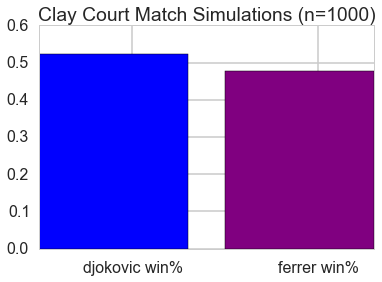

In [58]:
%matplotlib inline
x = ['djokovic win%','ferrer win%']
plt.bar([1], wins[0], color='b')
plt.bar([2], wins[1], color='purple')
plt.xlabel
plt.xticks([1.5,2.5],x)
plt.title('Clay Court Match Simulations (n=1000)')
plt.show()

In [59]:
n_match_simulator('novak-djokovic','david-ferrer',2011,'grass',1000)

novak-djokovic: 687 wins
david-ferrer: 313 wins


0.687

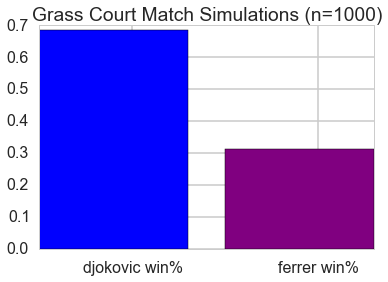

In [61]:
%matplotlib inline
x = ['djokovic win%','ferrer win%']
plt.bar([1], wins[0], color='b')
plt.bar([2], wins[1], color='purple')
plt.xlabel
plt.xticks([1.5,2.5],x)
plt.title('Grass Court Match Simulations (n=1000)')
plt.show()

Now we'll test these probabilities out at this year's season finale, the 2015 ATP World Tour Finals
Round Robin results. The winner is always entered as player one, so our final list represents the win probabilities we would have assigned to the actual winners beforehand. 

In [28]:
pairs = [['novak-djokovic','kei-nishikori'], ['roger-federer','tomas-berdych'],\
         ['andy-murray','david-ferrer'], ['rafael-nadal','stan-wawrinka'],\
         ['kei-nishikori','tomas-berdych'], ['roger-federer','novak-djokovic'],\
         ['stan-wawrinka','david-ferrer'], ['rafael-nadal','andy-murray'],\
         ['novak-djokovic','tomas-berdych'], ['roger-federer','kei-nishikori'],\
         ['stan-wawrinka','andy-murray'], ['rafael-nadal','david-ferrer'],\
         ['novak-djokovic','rafael-nadal'], ['roger-federer','stan-wawrinka'],\
         ['novak-djokovic','roger-federer']]

m = []
for i in xrange(len(pairs)):
    m.append(n_match_simulator(pairs[i][0],pairs[i][1], 2015, 'hard',1000))
m

novak-djokovic: 634 wins
kei-nishikori: 366 wins
roger-federer: 652 wins
tomas-berdych: 348 wins
andy-murray: 556 wins
david-ferrer: 444 wins
rafael-nadal: 625 wins
stan-wawrinka: 375 wins
kei-nishikori: 473 wins
tomas-berdych: 527 wins
roger-federer: 591 wins
novak-djokovic: 409 wins
stan-wawrinka: 355 wins
david-ferrer: 645 wins
rafael-nadal: 447 wins
andy-murray: 553 wins
novak-djokovic: 592 wins
tomas-berdych: 408 wins
roger-federer: 728 wins
kei-nishikori: 272 wins
stan-wawrinka: 325 wins
andy-murray: 675 wins
rafael-nadal: 459 wins
david-ferrer: 541 wins
novak-djokovic: 619 wins
rafael-nadal: 381 wins
roger-federer: 757 wins
stan-wawrinka: 243 wins
novak-djokovic: 431 wins
roger-federer: 569 wins


[0.634,
 0.652,
 0.556,
 0.625,
 0.473,
 0.591,
 0.355,
 0.447,
 0.592,
 0.728,
 0.325,
 0.459,
 0.619,
 0.757,
 0.431]

From these results, we see our match simulator gave the actual winner a win probability greater than 1/2 nine out of fifteen times. If we were to predict the player with the higher win percentage from "n_match_simulator," we would have achieved a 9/15 success rate in this case, which is comparable to our logistic regressions with ranking systems. In conclusion, it is hard to conclude the actual accuracy of this function, as it gives us a probability of players winning, when we can only compare probabilities against the results. Traditionally, a lot of matches in the ATP World Tour Finals are close (as only the world's top eight players are allowed entry), so it is not surprising that a lot of our final predictions leave us with win probabilities around 40-60%. Given this big uncertainty, our n_match_simulator can give insight into which player will have an edge, but also leads us to believe that many of these close match-ups are inherently difficult to predict.